#### Import Package

In [3]:
import pandas as pd
import dask.dataframe as dd
import swifter
import os
import cupy as cp
import string
import time
import json
import requests 
import tiktoken
import numpy as np
import ray
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
import openai
nltk.download('punkt')
nltk.download('stopwords')

from scipy.sparse import csr_matrix
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output
from openai import OpenAI
from sklearn.metrics import PrecisionRecallDisplay
from scipy.cluster import hierarchy as sch
from nltk.stem import PorterStemmer
from bertopic import BERTopic

from utils.system import *
from class_data.data import Data
from class_model.model import Model

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\weigfan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\weigfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data

In [2]:
# Multiple Articles per Day Data
wsj_multiple = Data(folder_path=get_format_data() / 'token', file_pattern='wsj_tokens_*')
wsj_multiple = wsj_multiple.concat_files()
# Set limit to the exact same value used in embedding_similarity.ipynb to align indexes
limit = 30
count = wsj_multiple.groupby(wsj_multiple.index)['accession_number'].count()
valid_dates_mask = count >= limit
wsj_multiple = wsj_multiple[wsj_multiple.index.isin(count[valid_dates_mask].index)]
print(wsj_multiple.shape)

(830899, 4)


#### Extract 

In [4]:
api_key = json.load(open(get_config() / 'api.json'))['openai_api_key']

def gpt_ngram(input):
    client = OpenAI(api_key=api_key)
    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "user", "content": f"Here is the input: {input}" +
                                        "\n\n :: " +
                                        "Enhance the input by extending it so that it still retains the input's meaning fully and DO NO OUTPUT THIS!!! " +
                                        "Next, create three different lists that store 5 unigrams, 5 bigrams, and 5 trigrams respectively in all lowercase. " +
                                        "\n\n Your output should not contain any additional comments or add-ons. YOU MUST ONLY OUTPUT THIS: " +
                                        "{\"unigram\": [\"(unigram1)\", ... , \"(unigram5)\"], " + 
                                        "\"bigram\": [\"(bigram1)\", ... , \"(bigram5)\"], " +
                                        "\"trigram\": [\"(trigram1)\", ... , \"(trigram5)\"]} "
            }
        ]
    )
    summary = response.choices[0].message.content.strip()
    start_index = summary.find('{')
    summary = summary[start_index:]
    data = json.loads(summary)
    return data

In [5]:
# User Input
input = "ESG"
# Extract ngram
ngram = gpt_ngram(input)

#### Preprocess

In [203]:
@ray.remote
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def preprocess_in_batches(df, new_column_name, column_name, batch_size):
    stop_words = set(stopwords.words('english'))
    num_batches = np.ceil(len(df) / batch_size)
    all_preprocess = []
    for i in tqdm(range(int(num_batches)), desc="Processing Batches..."):
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(df))
        batch = df[column_name][start_index:end_index]
        
        # Start asynchronous tasks for the batch
        futures = [preprocess.remote(text) for text in batch]
        preprocess_text = ray.get(futures)

        # Update lists
        all_preprocess.extend(preprocess_text)

    df[new_column_name] = all_preprocess
    return df

In [204]:
wsj_articles = wsj_multiple[['body_txt']].copy(deep=True)

In [205]:
ray.init(num_cpus=16, ignore_reinit_error=True)
wsj_preprocess = preprocess_in_batches(wsj_articles, 'preprocess', 'body_txt', 5000)
ray.shutdown()

2024-01-24 16:47:40,867	INFO worker.py:1507 -- Calling ray.init() again after it has already been called.
Processing Batches...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [06:02<00:00,  2.17s/it]


In [213]:
wsj_preprocess = wsj_preprocess[['preprocess']]

In [214]:
# Export Data
chunks = np.array_split(wsj_preprocess, 50)
for i, df in enumerate(chunks, 1):
    print(i)
    df.to_parquet(get_format_data() / 'preprocess' / f'wsj_preprocess_{i}.parquet.brotli', compression='brotli')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


#### TF-IDF

In [6]:
wsj_preprocess = Data(folder_path=get_format_data() / 'preprocess', file_pattern='wsj_preprocess_*')
wsj_preprocess = wsj_preprocess.concat_files()

In [7]:
# Fit tfidf
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_vectorizer.fit(wsj_preprocess['preprocess'])

TfidfVectorizer(max_features=1000)

In [4]:
@ray.remote
def get_tfidf(sub_batch, vectorizer):
    transformed = vectorizer.transform(sub_batch)
    return transformed

def get_tfidf_in_batches(df, vectorizer, new_column_name, column_name, batch_size, sub_batch_size):
    num_batches = np.ceil(len(df) / batch_size)
    collect = []

    for i in tqdm(range(int(num_batches)), desc="Processing Batches..."):
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(df))
        batch = df[column_name][start_index:end_index]

        # Split the batch into sub-batches
        sub_batches = [batch.iloc[j:j+sub_batch_size] for j in range(0, len(batch), sub_batch_size)]
        
        # Start asynchronous tasks for each sub-batch
        futures = [get_tfidf.remote(sub_batch, vectorizer) for sub_batch in sub_batches]
        sub_batch_results = ray.get(futures)

        # Flatten the results and update the collect list
        for result in sub_batch_results:
            collect.extend(result.toarray()) 

    df[new_column_name] = collect
    return df

In [5]:
ray.init(num_cpus=16, ignore_reinit_error=True)
wsj_tfidf = get_tfidf_in_batches(wsj_preprocess, tfidf_vectorizer, 'tfidf', 'preprocess', 1000, 50000)
ray.shutdown()

2024-01-24 20:50:50,444	INFO worker.py:1673 -- Started a local Ray instance.
Processing Batches...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 831/831 [11:43<00:00,  1.18it/s]


In [6]:
wsj_tfidf = wsj_tfidf[['tfidf']]

In [7]:
# Export Data
chunks = np.array_split(wsj_tfidf, 50)
for i, df in enumerate(chunks, 1):
    print(i)
    df.to_parquet(get_format_data() / 'tfidf' / f'wsj_tfidf_{i}.parquet.brotli', compression='brotli')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


#### Get Score

In [8]:
wsj_tfidf = Data(folder_path=get_format_data() / 'tfidf', file_pattern='wsj_tfidf_*')
wsj_tfidf = wsj_tfidf.concat_files()

In [9]:
def get_cos_sim_batch(computation, tfidf_vectorizer, tfidf_data, col, ngram, batch_size):
    data = tfidf_data.copy(deep=True)
    count = 0
    for key in ngram.keys():
        for input in ngram[key]:
            print(f"Input: {input}")
            # Transform the input string
            input_tfidf = tfidf_vectorizer.transform([input])
            
            # Split the data[col] into batches without stacking
            num_batches = len(data) // batch_size + 1
            comp_batches = []
            
            for batch_num in tqdm(range(num_batches)):
                start_idx = batch_num * batch_size
                end_idx = min((batch_num + 1) * batch_size, len(data))
                matrix_batch = np.stack(data[col][start_idx:end_idx].values)

                if computation == 'mult':
                    # Compute matrix multiplication
                    comp_batch = np.dot(input_tfidf, matrix_batch.T)
                    comp_batches.append(comp_batch)
                elif computation == 'cos_sim':
                    # Compute cosine similarity
                    comp_batch = cosine_similarity(input_tfidf, matrix_batch)
                    comp_batches.append(comp_batch)
            
            # Concatenate the cosine similarity batches
            score = np.concatenate([arr[0] for arr in comp_batches])
            
            # Create column name with key
            column_name = f'score_{count}'
            data[column_name] = score
            count+=1
    return data

In [10]:
cos_sim = get_cos_sim_batch('cos_sim', tfidf_vectorizer, wsj_tfidf, 'tfidf', ngram, 100)

Input: esg


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1004.34it/s]


Input: environmental


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 995.54it/s]


Input: social


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1014.48it/s]


Input: governance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1033.18it/s]


Input: sustainability


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:07<00:00, 1047.95it/s]


Input: environmental social


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1034.49it/s]


Input: social governance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1037.85it/s]


Input: esg factors


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 1034.81it/s]


Input: esg performance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:07<00:00, 1063.01it/s]


Input: sustainability governance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:07<00:00, 1043.69it/s]


Input: environmental social governance


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:07<00:00, 1040.03it/s]


Input: esg sustainability metrics


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:07<00:00, 1054.62it/s]


Input: measuring esg performance


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 988.03it/s]


Input: impact of esg


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 999.60it/s]


Input: esg investment strategies


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8309/8309 [00:08<00:00, 988.54it/s]


#### Create Index

In [11]:
# Generate Index
cos_sim_filter = cos_sim[cos_sim.columns[1:]]
cos_sim_mean = cos_sim_filter.mean(axis=1).to_frame('score_mean')
index = cos_sim_mean.groupby('date').mean()

<Axes: xlabel='date'>

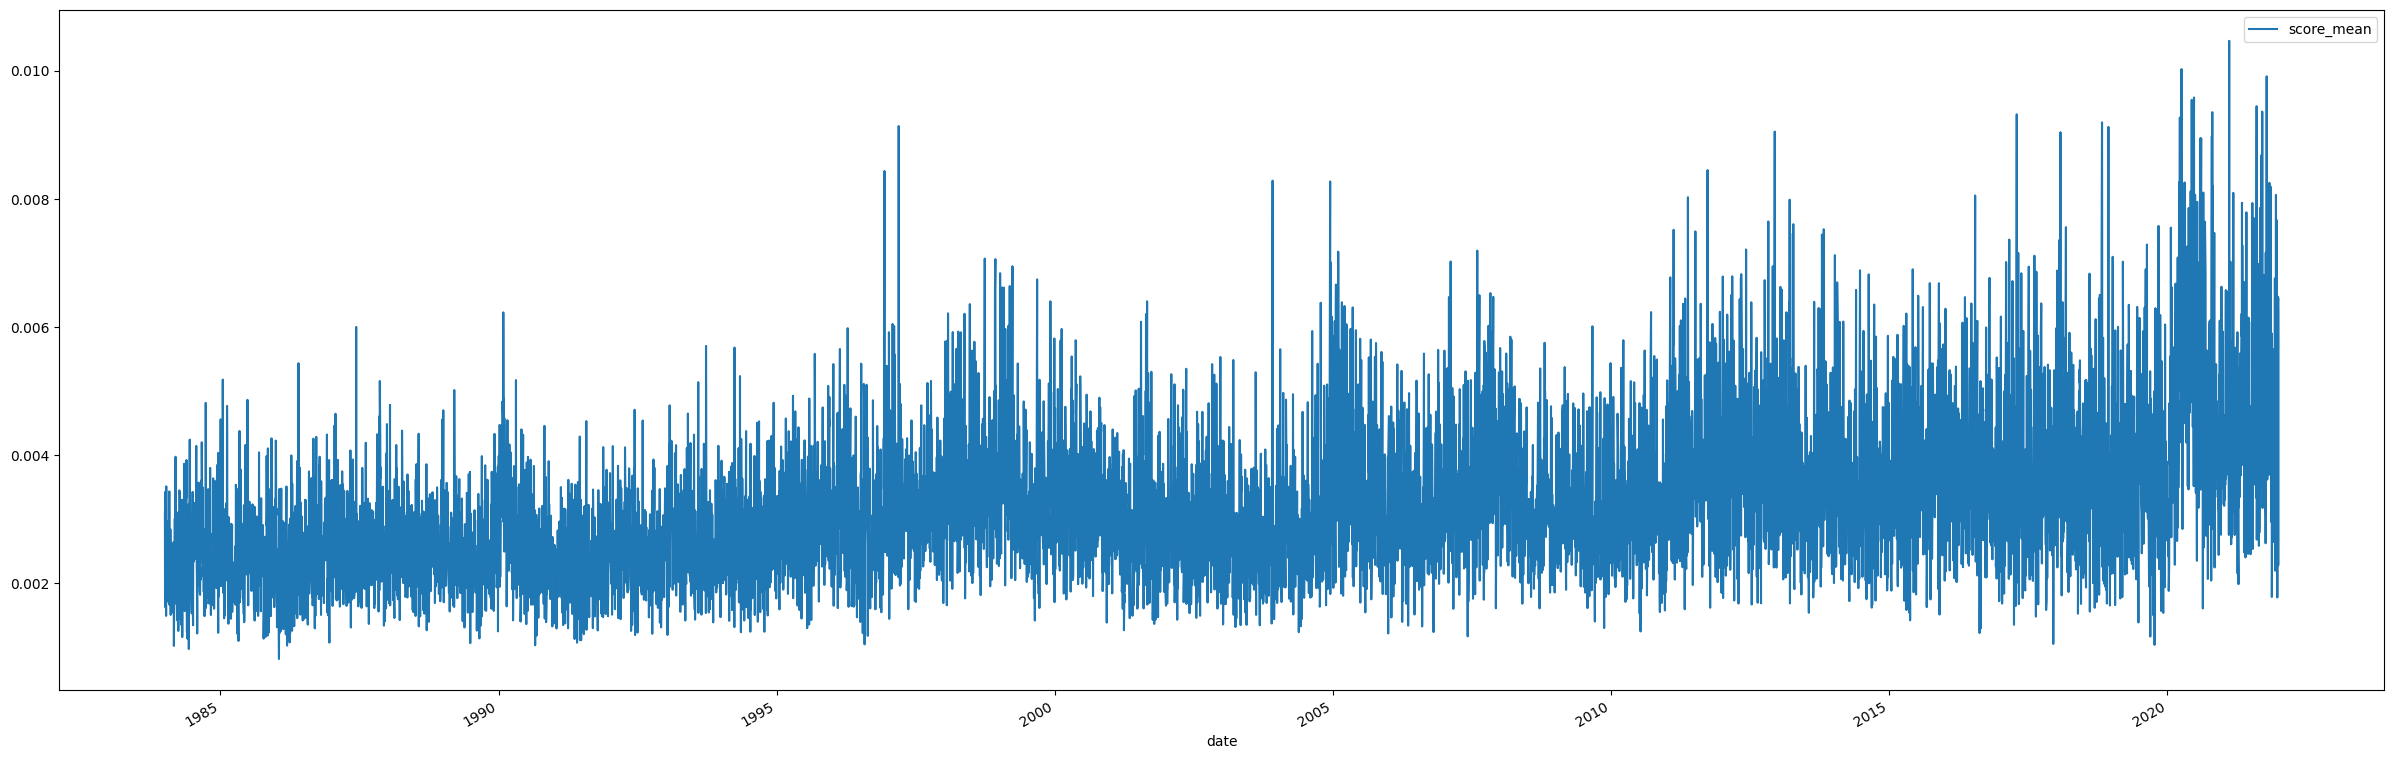

In [21]:
index.plot(figsize=(30, 10))